In [1]:
!nvidia-smi


Wed Feb  8 20:26:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8     3W /  50W |    384MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [2]:
# Import helper function
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir,pred_and_plot

## Let's get some data
This time we're going to see how we can use the pretraied models within tf.keras.applications and apply them to our owm problem(recognizing images of our food)

In [3]:
unzip_data("10_food_classes_10_percent.zip")

In [4]:
## Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percen

In [5]:
# Create training and test directory paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [6]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(
               directory=train_dir,
               image_size=IMG_SIZE,
               label_mode="categorical",
               batch_size=BATCH_SIZE
)

test_data=tf.keras.preprocessing.image_dataset_from_directory(
       test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
#Check out the classes  names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images ,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[ 30.07653    27.07653    20.07653  ]
   [ 25.163265   24.163265   19.163265 ]
   [ 29.061224   28.27551    24.704082 ]
   ...
   [158.21933   143.21933   110.21934  ]
   [152.14287   137.14287   105.33673  ]
   [153.10197   138.10197   105.92847  ]]

  [[ 26.67347    23.67347    18.67347  ]
   [ 25.510206   24.510206   19.510206 ]
   [ 30.760202   29.97449    26.40306  ]
   ...
   [160.47453   145.47453   116.33167  ]
   [152.72957   137.72957   108.71936  ]
   [152.07143   137.07143   108.0204   ]]

  [[ 31.795918   29.224491   24.438776 ]
   [ 28.571426   27.571426   24.       ]
   [ 20.857143   20.857143   19.62245  ]
   ...
   [151.94397   136.3266    109.08686  ]
   [152.6735    136.94391   110.102036 ]
   [154.71936   139.21428   111.57643  ]]

  ...

  [[ 99.07147   111.285736   27.714264 ]
   [ 92.18368   105.12755    23.127552 ]
   [ 86.57143   100.29079    19.999977 ]
   ...
   [168.9336    139.76524    99.765236 ]
   [163.05614   135.05614    95.05614  ]
   [1

## Model 0: Building a transfer learning feature extraction model using Kearas Functional API
The Sequential API is straight-foward , it runs our layers in sequential order.


But the functional API gives us more flexiblity with our models

In [10]:
#1. Create base model with tf.keras.application
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
#2. Freeze base model
base_model.trainable=False
#3. create inputs into our model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="Input_layer")
#4. If using model like ResNet50V2 you need to  normalize inputs
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
#5. pass the inputs to base model
x=base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

#6. Average pool the outputs of the base model (aggregate all the most important information , reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="golabel_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")
#7. Create the output activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="Output_layer")(x)

#8. combine inputs and outputs into a model
model_0=tf.keras.Model(inputs,outputs)
#9 Compile model
model_0.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]  
)
#10. Fit model and save history
history_0=model_0.fit(
  train_data_10_percent,
  epochs=5,
  steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                           experiment_name="10_percent_feature_extraction"
                                          )]
)

Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230208-202635
Epoch 1/5
24/24 [==============================] - 23s 339ms/step - loss: 1.9277 - accuracy: 0.3827 - val_loss: 1.3545 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - 6s 237ms/step - loss: 1.1198 - accuracy: 0.7707 - val_loss: 0.8853 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 6s 233ms/step - loss: 0.7936 - accuracy: 0.8280 - val_loss: 0.7008 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 6s 233ms/step - loss: 0.6441 - accuracy: 0.8520 - val_loss: 0.6252 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 6s 234ms/step - loss: 0.5459 - accuracy: 0.8773 - val_loss: 0.5524 - val_accuracy: 0.8668


In [11]:
# Evaluate full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.5596 - accuracy: 0.8584


[0.5595987439155579, 0.8583999872207642]

In [12]:
# Check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [13]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [14]:
#summary of whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 golabel_average_pooling_lay  (None, 1280)             0         
 er (GlobalAveragePooling2D)                                     
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


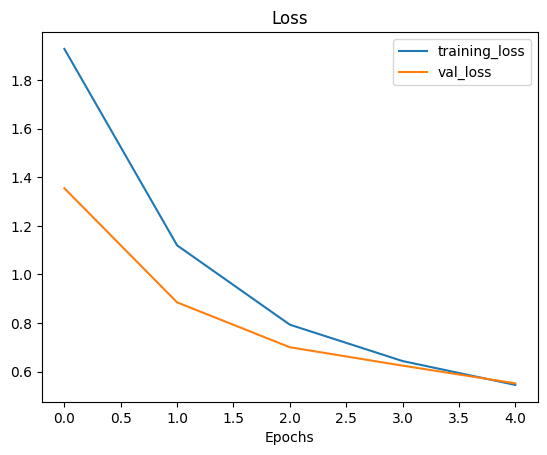

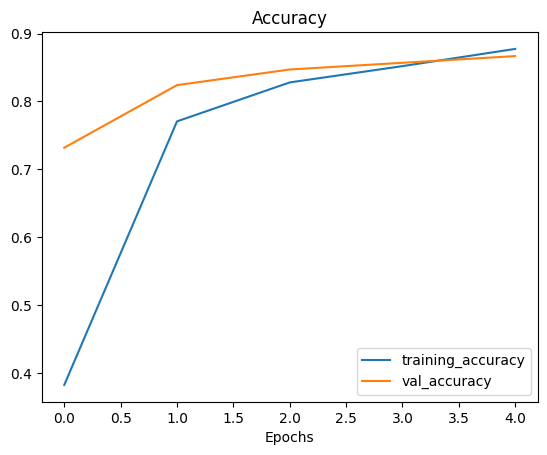

In [15]:
#Plot loss curves
plot_loss_curves(history_0)

## Getting a feature vector from trained model
Let's demostrate the Global Average Pooling 2D layer


In [16]:
## Define input shape
input_shape=(1,4,4,3)

#Create random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

# Pass the random tensor to global average pooling 2D
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

#Check shape of different tensor
print(f"Shape of input tensor:{input_tensor.shape}\n")
print(f"Shape of Glovbal Average Pooled tensor:{global_average_pooled_tensor.shape}\n")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:(1, 4, 4, 3)

Shape of Glovbal Average Pooled tensor:(1, 3)



In [17]:
# Let's replicate the GlobalAveragePool2D layers
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [18]:
## Define input shape
input_shape=(1,4,4,3)

#Create random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

# Pass the random tensor to global average pooling 2D
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

#Check shape of different tensor
print(f"Shape of input tensor:{input_tensor.shape}\n")
print(f"Shape of Glovbal Max Pooled tensor:{global_average_pooled_tensor.shape}\n")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:(1, 4, 4, 3)

Shape of Glovbal Max Pooled tensor:(1, 3)



## Note: Feature vector is learned representation of our input data 

## Running a series of transfer learning experiments
Model 1: use feature extraction transfer learning with 1% of training data with data augmentation

Model 2: 10% of training data

Model 3: Fine tuning with 10 % data

Model 4: Fine tuning with 100% of data    

Note: Same test data set will be use to evaluate the model    

## Preprocessing for Model_1

## Unzip 1 % of data

In [19]:
unzip_data("10_food_classes_1_percent.zip")

In [20]:
# Create train and test dir
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir_1_percent="10_food_classes_1_percent/test"

In [21]:
# how many images
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [22]:
#Set up data loader
IMG_SIZE=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE
                                                                        )

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE
                                                             )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [23]:
## Adding data augmentation right into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
#Create data augmentation with horizontal flipping , rotation , zooms etc
data_augmentation=keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
#     preprocessing.Resizing(224,224)
#     preprocessing.Rescaling(1./255)
],name="data_augmentation")

### Visualize our data augmentation layer

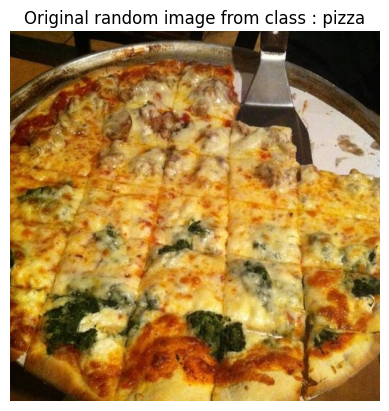

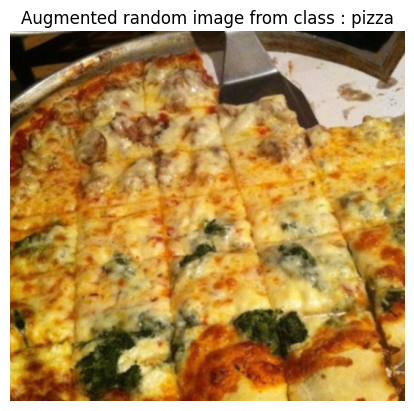

In [24]:
# View a ranndom image and compare it to augmentated version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/"+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+"/"+random_image

#Read in the random image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class : {target_class}")
plt.axis(False);

#Plot augmented random image
augmented_img=data_augmentation(img/255.,training=True)
plt.figure()
plt.title(f"Augmented random image from class : {target_class}")
plt.imshow(augmented_img)
plt.axis(False);

# Model 1 : Feature extraction transfer learning on 1 % of data with data augmentation

In [25]:
# Setup input shape and base model , freezing the base model layers
from tensorflow.keras.optimizers import Adam
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer
inputs=layers.Input(shape=input_shape,name="Input layer")

# Add in data augmentation model as a laywer
x=data_augmentation(inputs)

#Give base model the inputs (after augmentation) and don't train it
x=base_model(x,training=False)

#Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="Pooling_layer")(x)

#Put a dense layer as on output
outputs=layers.Dense(10,activation="softmax",name="output_layer")(x)

#Make a model using inputs and outputs
model_1=keras.Model(inputs,outputs)

#Compile
model_1.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=Adam(),
  metrics=["accuracy"]  
)

#Fit the model
history_1_percent=model_1.fit(train_data_1_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_1_percent),
                             validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_perent_data_aug"
                                                                    )]
                             )

Saving TensorBoard log files to: transfer_learning/1_perent_data_aug/20230208-202742
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.4142 - accuracy: 0.1000 - val_loss: 2.2054 - val_accuracy: 0.1908
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1629 - accuracy: 0.2429 - val_loss: 2.0838 - val_accuracy: 0.2681
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9173 - accuracy: 0.4429 - val_loss: 1.9800 - val_accuracy: 0.3339
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7883 - accuracy: 0.5000 - val_loss: 1.8518 - val_accuracy: 0.4638
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5866 - accuracy: 0.7143 - val_loss: 1.7671 - val_accuracy: 0.5099


In [26]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
#Evaluate full dataset
result_1_percent_data_aug=model_1.evaluate(test_data)

79/79 [==============================] - 10s 125ms/step - loss: 1.7733 - accuracy: 0.4972


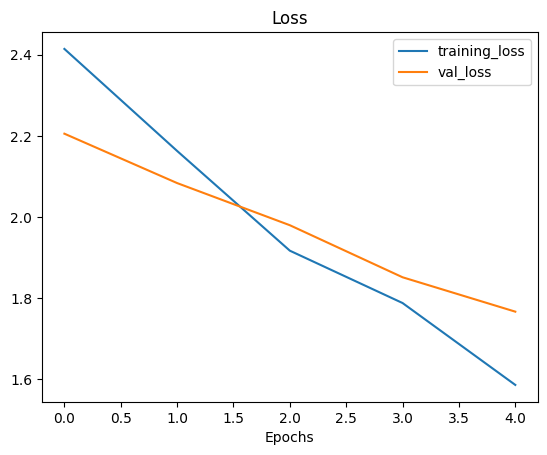

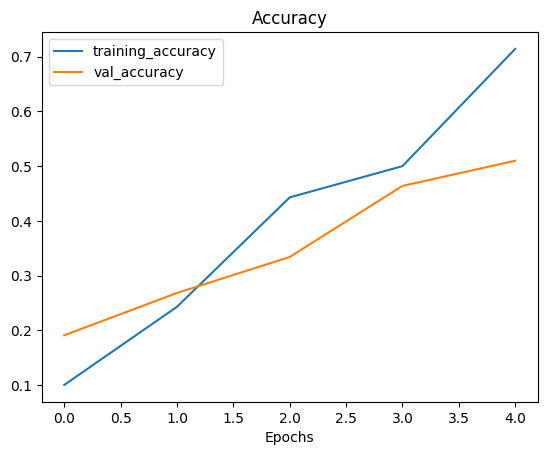

In [28]:
plot_loss_curves(history_1_percent)

## Model 2 - Feature extraction transfer learning with 10 % of data

In [29]:

# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [30]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)
     

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])
     


In [32]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [33]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 golabel_average_pooling_lay  (None, 1280)             0         
 er (GlobalAveragePooling2D)                                     
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a modelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training . This is useful so we can come and start where we left off.

In [34]:

# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)
     

## Fit model 2 passing in ModelCheckpoint callback

In [35]:

# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230208-202830
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9806 - accuracy: 0.3840
Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 29s 908ms/step - loss: 1.9806 - accuracy: 0.3840 - val_loss: 1.4114 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2898 - accuracy: 0.7053
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 15s 630ms/step - loss: 1.2898 - accuracy: 0.7053 - val_loss: 0.9995 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9761 - accuracy: 0.7733
Epoch 3: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 14s 572ms/step - loss: 0.9761 - accuracy: 0.7733 - val_loss: 0.7813 - val_accuracy: 0.8043
E

In [36]:
#What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 11s 121ms/step - loss: 0.5596 - accuracy: 0.8584


[0.559598982334137, 0.8583999872207642]

In [37]:
#Check model 2 results on all test data
result_10_percent_data_aug=model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 10s 120ms/step - loss: 0.6268 - accuracy: 0.8360


[0.6267683506011963, 0.8360000252723694]

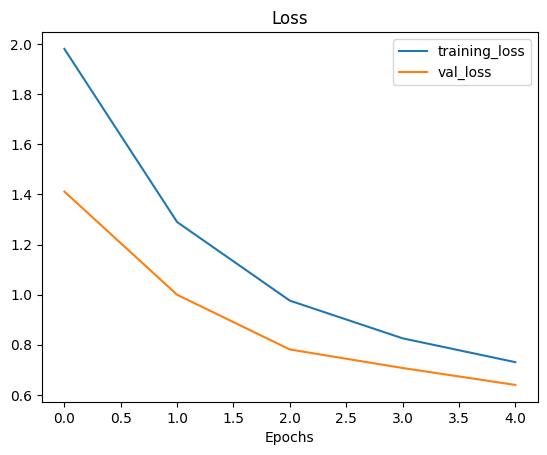

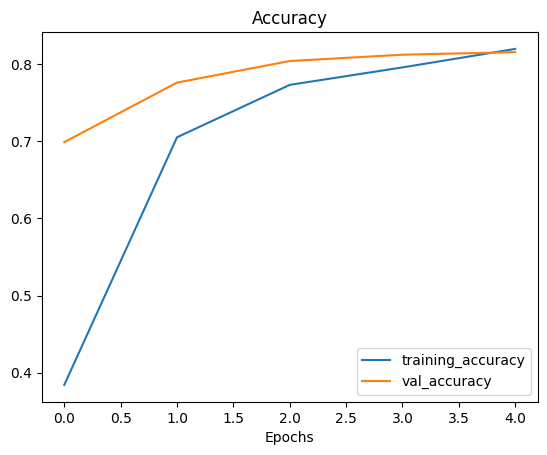

In [38]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.


In [39]:
#Load in save model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [40]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 10s 120ms/step - loss: 0.6268 - accuracy: 0.8360


In [41]:
# If results from our previous evaluated model_2 match the loaded weights , everything worked
result_10_percent_data_aug==loaded_weights_model_results

True

## Model 3: Fine-tuning  an existing model on 10% of the data

**Note**: Fine-tuning usually works best  *after* training a feature extraction model for a few epochs with large amount of custom data

In [42]:
# Layers in loaded model
model_2.layers

In [43]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002596870B370> True
<keras.engine.sequential.Sequential object at 0x0000025957FB9720> True
<keras.engine.functional.Functional object at 0x00000259688845E0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000002596870BA60> True
<keras.layers.core.dense.Dense object at 0x0000025957FB9300> True


In [44]:
#What layers are in our base model (EfficientNetBO) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers) :
    print(i, layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [45]:
# How many trainable variables are in our model?
print(len(model_2.layers[2].trainable_variables))

0


In [46]:
# To begin fine tuning , let's start by setting the last 10 layers  of our base_model.trainable=True
base_model.trainable=True

#Freeze all layers except the last 10
for layers in base_model.layers[:-10]:
    layers.trainable=False
    
# Recompile (we have to complile our model every time we make a change)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=Adam(learning_rate=0.0001), #lower the lr by 10x in fine tuning
                metrics=["accuracy"]
               )

**Note** : When use fine tuning , decrease lr by 10x

In [47]:
#Check which layers are tunable(trainanle
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [48]:
#trainable variable now
print(len(model_2.trainable_variables))

12


In [49]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [50]:
# Fine tune for another 5 epochs
fine_tune_epochs=initial_epochs+5

#Refit the model (same as model 2 but with more trainable layers)
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             validation_steps=int(0.25*len(test_data)),
                                             initial_epoch=history_10_percent_data_aug.epoch[-1],#start training from previous last epoch
                                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="10_percent_fine_tune_last_10_layers"
                                                                                   )]
                                            )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10_layers/20230208-203027
Epoch 5/10
24/24 [==============================] - 24s 720ms/step - loss: 0.6171 - accuracy: 0.8307 - val_loss: 0.4944 - val_accuracy: 0.8339
Epoch 6/10
24/24 [==============================] - 15s 614ms/step - loss: 0.5114 - accuracy: 0.8467 - val_loss: 0.4664 - val_accuracy: 0.8339
Epoch 7/10
24/24 [==============================] - 13s 542ms/step - loss: 0.4497 - accuracy: 0.8667 - val_loss: 0.4215 - val_accuracy: 0.8503
Epoch 8/10
24/24 [==============================] - 14s 564ms/step - loss: 0.3897 - accuracy: 0.8867 - val_loss: 0.4353 - val_accuracy: 0.8454
Epoch 9/10
24/24 [==============================] - 14s 584ms/step - loss: 0.3586 - accuracy: 0.8933 - val_loss: 0.4243 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 12s 512ms/step - loss: 0.3337 - accuracy: 0.8973 - val_loss: 0.4480 - val_accuracy: 0.8273


In [51]:
#Evaluate
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 10s 122ms/step - loss: 0.4281 - accuracy: 0.8540


In [52]:
result_10_percent_data_aug

[0.6267683506011963, 0.8360000252723694]

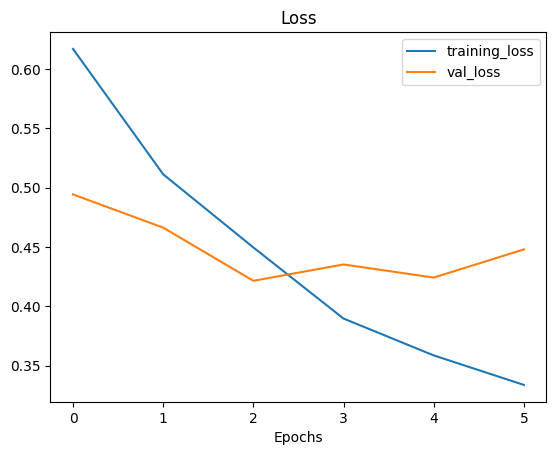

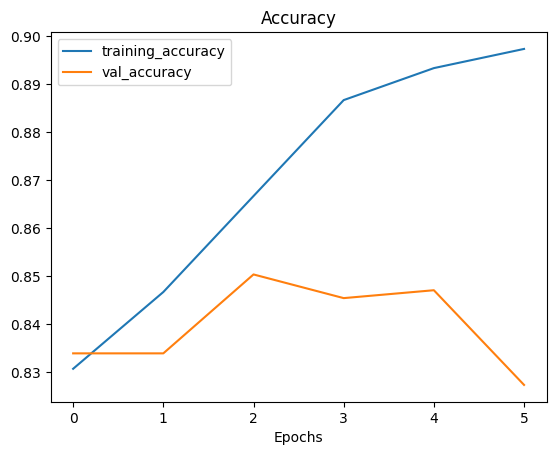

In [53]:
#Plot loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

Note: The plot loss function works great with models which have only fit once, however we want something to compare one series to fit with another

In [54]:
# Let's create a function to compare training histories
def compare_historys(original_history,new_history,initial_epochs=5 ):
    
    """
    Compares 2 Tensorflow History objects.
    """
    #Get original history measurements
    acc=original_history.history["accuracy"]
    loss=original_history.history["loss"]
    
    val_acc=original_history.history["val_accuracy"]
    val_loss=original_history.history["val_loss"]
    
    #Combine original history metrics with new history metrics
    total_acc=acc+new_history.history["accuracy"]
    total_loss=loss+new_history.history["loss"]
    
    total_val_acc=acc+new_history.history["val_accuracy"]
    total_val_loss=loss+new_history.history["val_loss"]
    
    #Make plots for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc,label="Training Accuracy")
    plt.plot(total_val_acc,label="Val Accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    
    
    #Make plots for loss
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss,label="Training Loss")
    plt.plot(total_val_loss,label="Val Loss")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

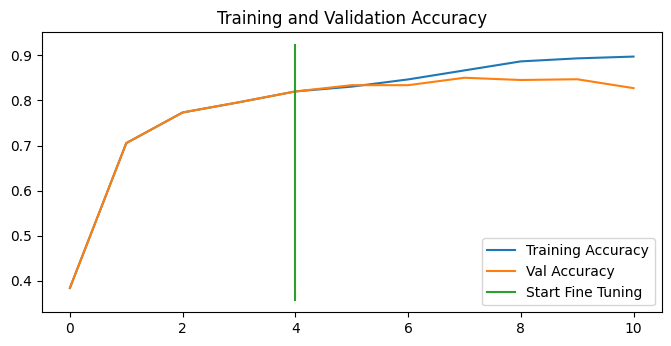

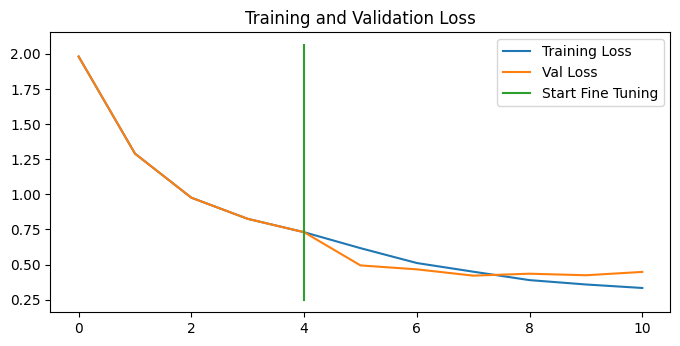

In [55]:
compare_historys(history_10_percent_data_aug,history_fine_10_percent_data_aug,
                 initial_epochs=5
                )

In [56]:
## Model 4 : Fine tunning exisiting model on all of the data
unzip_data("10_food_classes_all_data.zip")

In [57]:
#Setup training and test dir
train_dir_all_data="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [58]:
#How many images
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [59]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_classes_full=tf.keras.preprocessing.image_dataset_from_directory( 
 directory=train_dir_all_data,
 label_mode="categorical",
 image_size=IMG_SIZE 
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode="categorical",
   image_size=IMG_SIZE 
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [60]:
#Evaluate model 2 (fine tune 10 % of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 10s 122ms/step - loss: 0.4281 - accuracy: 0.8540


[0.4280923306941986, 0.8539999723434448]

In [61]:
results_fine_tune_10_percent

[0.42809224128723145, 0.8539999723434448]

## To train a fine-tune model (model 4) we need to revert model_2 back to its feature extraction weights

In [62]:
# Load in weights from checkpoint 
model_2.load_weights(checkpoint_path)

In [63]:
#let's evaluate model 2 
model_2.evaluate(test_data)

79/79 [==============================] - 10s 122ms/step - loss: 0.6268 - accuracy: 0.8360


[0.6267683506011963, 0.8360000252723694]

In [64]:
#Check if this is reverted
result_10_percent_data_aug

[0.6267683506011963, 0.8360000252723694]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.
The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable

In [65]:
#check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [66]:
#Drill our base model and see which layer are trainable
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [67]:
#Compile
model_2.compile(
  loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [68]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230208-203254
Epoch 5/10
235/235 [==============================] - 103s 408ms/step - loss: 0.6619 - accuracy: 0.7891 - val_loss: 0.3632 - val_accuracy: 0.8799
Epoch 6/10
235/235 [==============================] - 85s 362ms/step - loss: 0.5295 - accuracy: 0.8296 - val_loss: 0.3175 - val_accuracy: 0.8799
Epoch 7/10
235/235 [==============================] - 75s 317ms/step - loss: 0.4645 - accuracy: 0.8501 - val_loss: 0.3036 - val_accuracy: 0.8849
Epoch 8/10
235/235 [==============================] - 71s 302ms/step - loss: 0.4338 - accuracy: 0.8592 - val_loss: 0.2845 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 66s 282ms/step - loss: 0.3914 - accuracy: 0.8760 - val_loss: 0.3001 - val_accuracy: 0.8947
Epoch 10/10
235/235 [==============================] - 64s 271ms/step - loss: 0.3626 - accuracy: 0.8831 - val_loss: 0.2784 - val_accuracy: 0.9112


In [69]:
#Let's evaluate on all of the test data
results_fine_tune_full_data=model_2.evaluate(test_data)

79/79 [==============================] - 10s 120ms/step - loss: 0.2618 - accuracy: 0.9160


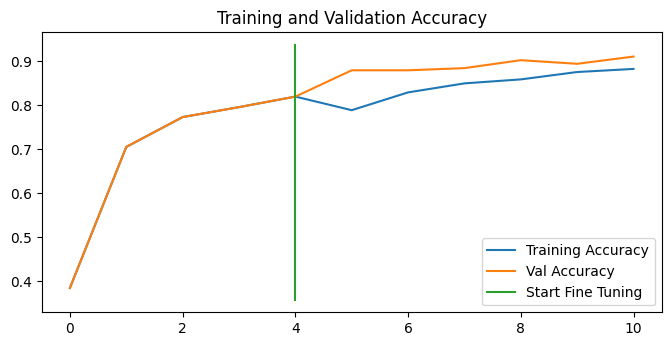

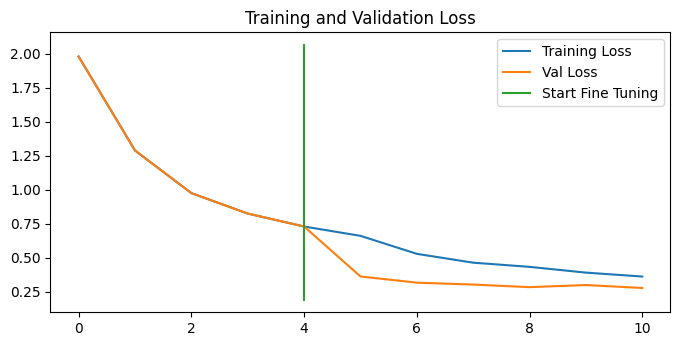

In [70]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5
                )

In [71]:
model_2.save("Best_model.h5")

In [72]:
best_model=tf.keras.models.load_model("Best_model.h5")

In [73]:
best_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [74]:
print(tf.__version__)

2.9.0


# Excersise:

## Ques1: Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [75]:
import tensorflow as tf

In [76]:
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [78]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(224,224),
                                                              label_mode="categorical",
                                                               batch_size=32
                                                              )

Found 750 files belonging to 10 classes.


In [79]:
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=(224,224),
                                                              label_mode="categorical",
                                                              batch_size=32
                                                             )

Found 2500 files belonging to 10 classes.


In [81]:
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation=tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2)
],name="Augmentation_layer")

In [82]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

In [86]:
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name="Average_pooling_layers")(x)
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
model_ex=tf.keras.Model(inputs,outputs)

In [88]:
model_ex.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics=["accuracy"] 
)

In [89]:
checkpoint_path="Excersise_Path/checkpoint.ckpt"

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=False,
                                                       save_freq="epoch",
                                                       verbose=1
                                                      )

In [90]:
initial_epochs=10
history_ex_1=model_ex.fit(train_data,epochs=initial_epochs,
                          validation_data=test_data,
                          validation_steps=int(0.25*len(test_data)),
                          callbacks=[checkpoint_callback]
                         )

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9646 - accuracy: 0.3493
Epoch 1: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 16s 379ms/step - loss: 1.9646 - accuracy: 0.3493 - val_loss: 1.3892 - val_accuracy: 0.7039
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.2918 - accuracy: 0.6920
Epoch 2: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 8s 326ms/step - loss: 1.2918 - accuracy: 0.6920 - val_loss: 0.9708 - val_accuracy: 0.8125
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.7773
Epoch 3: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 8s 305ms/step - loss: 0.9925 - accuracy: 0.7773 - val_loss: 0.8011 - val_accuracy: 0.8158
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.7960
Epoch 4: saving model to Excersise_Path\checkpoint.ckpt
24/24 

In [91]:
base_model.trainable=True

for layers in base_model.layers[:-20]:
    layers.trainable=False

In [92]:
for layer_number,layer in enumerate(model_ex.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 tf.math.truediv_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [93]:
model_ex.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(),
 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
 metrics=["accuracy"]   
)

In [94]:
second_epochs=initial_epochs+10
history_ex_2=model_ex.fit(train_data,epochs=second_epochs,
                          validation_data=test_data,
                          validation_steps=int(0.25*len(test_data)),
                          callbacks=[checkpoint_callback],
                          initial_epoch=history_ex_1.epoch[-1]
                         )

Epoch 10/20
24/24 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8773
Epoch 10: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 15s 395ms/step - loss: 0.4393 - accuracy: 0.8773 - val_loss: 0.4825 - val_accuracy: 0.8487
Epoch 11/20
24/24 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8987
Epoch 11: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 7s 293ms/step - loss: 0.3424 - accuracy: 0.8987 - val_loss: 0.4699 - val_accuracy: 0.8503
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.9267
Epoch 12: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 8s 319ms/step - loss: 0.2689 - accuracy: 0.9267 - val_loss: 0.4341 - val_accuracy: 0.8651
Epoch 13/20
24/24 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9360
Epoch 13: saving model to Excersise_Path\checkpoint.ckp

In [95]:
model_ex.evaluate(test_data)

79/79 [==============================] - 10s 118ms/step - loss: 0.4171 - accuracy: 0.8712


[0.4171134829521179, 0.8712000250816345]

In [96]:
base_model.trainable=True

for layers in base_model.layers[:-30]:
    layers.trainable=False

In [97]:
model_ex.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(),
 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
 metrics=["accuracy"]   
)

In [100]:
second_epochs=initial_epochs+20
history_ex_3=model_ex.fit(train_data,epochs=second_epochs,
                          validation_data=test_data,
                          validation_steps=int(0.25*len(test_data)),
                          callbacks=[checkpoint_callback],
                          initial_epoch=history_ex_2.epoch[-1]
                         )

Epoch 20/30
24/24 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9840
Epoch 20: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 7s 286ms/step - loss: 0.0565 - accuracy: 0.9840 - val_loss: 0.5812 - val_accuracy: 0.8355
Epoch 21/30
24/24 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9987
Epoch 21: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 7s 292ms/step - loss: 0.0385 - accuracy: 0.9987 - val_loss: 0.5513 - val_accuracy: 0.8520
Epoch 22/30
24/24 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9933
Epoch 22: saving model to Excersise_Path\checkpoint.ckpt
24/24 [==============================] - 7s 288ms/step - loss: 0.0347 - accuracy: 0.9933 - val_loss: 0.5178 - val_accuracy: 0.8766
Epoch 23/30
24/24 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9960
Epoch 23: saving model to Excersise_Path\checkpoint.ckpt

In [101]:
model_ex.evaluate(test_data)

79/79 [==============================] - 10s 121ms/step - loss: 0.4958 - accuracy: 0.8728


[0.4957524836063385, 0.8727999925613403]

In [105]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [108]:

# Creating a function that would grab the image from a dataset, visualize and gives the prediction of it. 

def dataset_visualizer(dataset , model):
  '''
  Arguments: 
    dataset --> `tf.data.Dataset` object with (image , label) tuples 
    model --> the trained model 

  Returns: 
    Visualizae the image from the dataset and the prediction class of the image. 
  '''
  image_batch , label_batch = dataset.as_numpy_iterator().next() 
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}" , c = title_color)
    plt.axis('off')
    

1/1 [==============================] - 0s 28ms/step


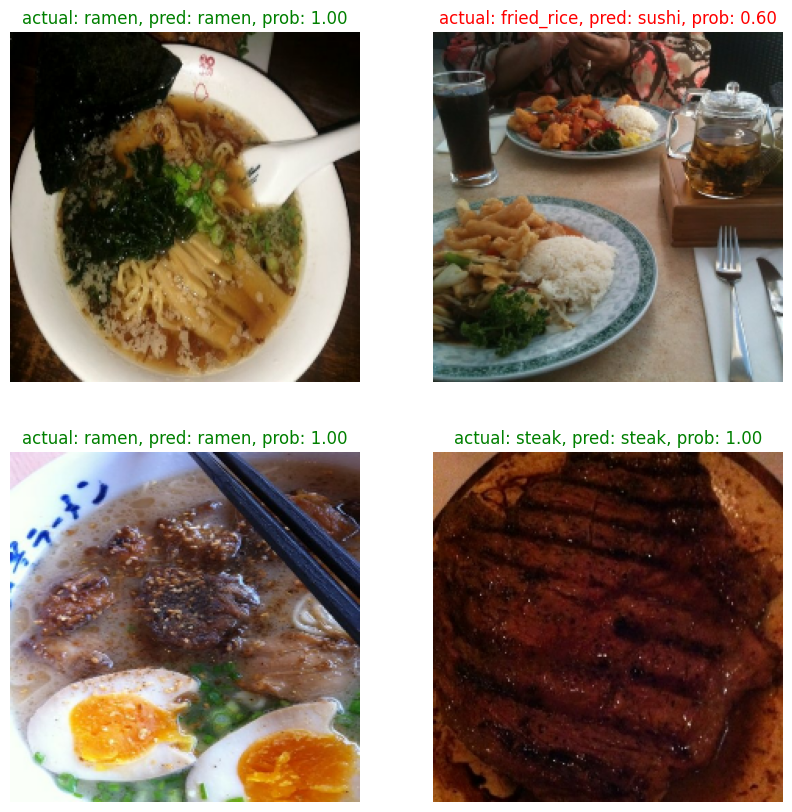

In [112]:
dataset_visualizer(test_data , model_ex)